SMITE is a third-person MOBA developed by Titan Forge Games. In the primary competitive mode of SMITE, players on teams of five select combinations of deities from a pool of over 100, and then must choose 6 items to purchase from a pool of over 250+ items throughout the game. This project focuses on the second of these challenges, attempting to provide a beginner-friendly guide to which items are currently performing well on particular deities.

There is a plethora of information available from SMITE's developer API, including kills, deaths, and assists, damage dealt, taken, and mitigated, and team and self healing. To begin, I will explore the connections between a player's performance statistics and their likelihood of victory.

I will investigate both engineered features (such as K+A / D, or DM + SH / DT, or any other interesting combinations) alongside the raw features themselves to see if there is a linear or nonlinear relationship between these features and victory.

Next, I will explore the relationship between a player's performance and the items they ended the game with. While I cannot see the items purchased or sold throughout the game, the structure of the in-game economy discourages selling most purchased items. As such, this is the highest resolution data available. Additionally, I prune my information (restricting to t3+ items) to prevent skewing.

In [92]:
import json
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
from tqdm import tqdm

from typing import Any, Dict, NamedTuple
import os
from copy import deepcopy

In [65]:
class ColPercentile(NamedTuple):
    ten: float
    ninety: float

raw_col_names = (
    'assists', 
    'damage_mitigated', 
    'damage_player', 
    'damage_taken', 
    'deaths', 
    'healing', 
    'healing_player_self', 
    'kills_player', 
    'structure_damage',
)

col_names = (
    'BIAS', 
    'assists', 
    'damage_mitigated', 
    'damage_player', 
    'damage_taken', 
    'deaths', 
    'healing', 
    'healing_player_self', 
    'kills_player', 
    'structure_damage', 
    'net_damage_taken',
    'win_status',
    'match_id',
)

def in_bounds(row: Dict[str, Any], col_perc_dict: Dict[str, ColPercentile]) -> bool:
    inbounds = [False] * len(raw_col_names)
    for idx, col in enumerate(raw_col_names):
        if col_perc_dict[col].ten <= (row[col] / row["match_time_minutes"]) <= col_perc_dict[col].ninety:
            inbounds[idx] = True

    return all(inbounds)

def data_to_df(path: str) -> pd.DataFrame:
    with open(path) as infile:
        raw_data = [
            x 
            for x in json.loads(''.join(infile.readlines()))
            if x["match_time_minutes"] >= 15
        ]
            
    col_perc_dict = {}
    for col in raw_col_names:
        col_list = [x[col] / x["match_time_minutes"] for x in raw_data]
        col_perc_dict[col] = ColPercentile(
            ten=np.percentile(col_list, 10),
            ninety=np.percentile(col_list, 90)
        )
    data = np.array(
        [
            np.append(
                np.divide(
                    np.array(
                        [
                            x["assists"],
                            x["damage_mitigated"],
                            x["damage_player"],
                            x["damage_taken"],
                            x["deaths"],
                            x["healing"],
                            x["healing_player_self"],
                            x["kills_player"],
                            x["structure_damage"],
                            ((x["damage_mitigated"] + x["healing_player_self"] - x["damage_taken"]) / (x["damage_player"] if x["damage_player"] != 0 else 1)),
                        ]
                    ),
                    x["match_time_minutes"],
                ),
                [
                    1 if x["win_status"] == "Winner" else 0,
                    x["match_id"]
                ]
                
            )
            for x in raw_data if in_bounds(x, col_perc_dict)
        ]
    )
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(data[:,:-2])
    bias = np.ones((data.shape[0], 1))
    data = np.hstack((bias, data))
    df = pd.DataFrame(data, columns=col_names)
    return df
    
all_dfs = []
root = '/home/jack/pCloudDrive/SmiteData/conquest_match_data'
files = os.listdir(root)
for file in tqdm(files):
    all_dfs.append(data_to_df(os.path.join(root, file)))

df = data_to_df('/home/jack/pCloudDrive/SmiteData/conquest_match_data/1649.json')

100%|██████████| 111/111 [00:24<00:00,  4.60it/s]


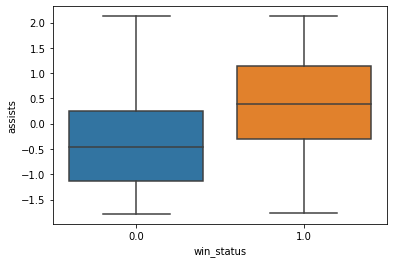

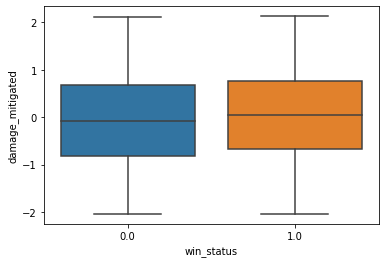

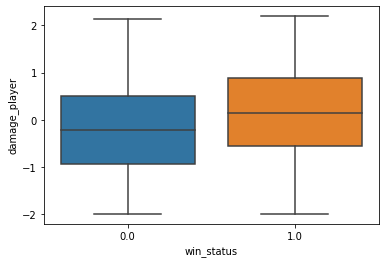

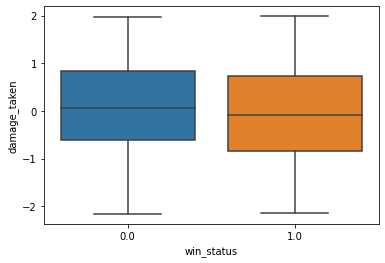

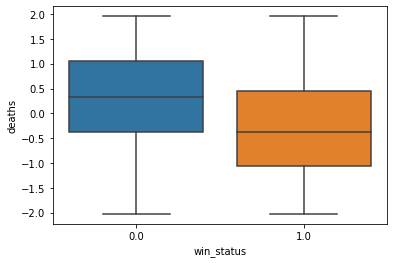

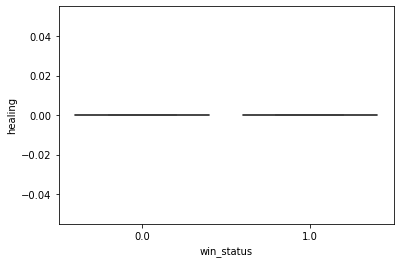

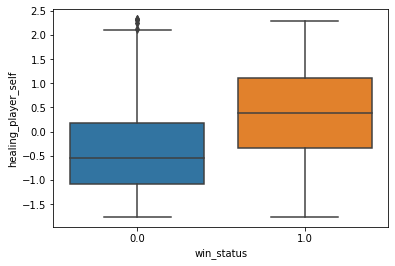

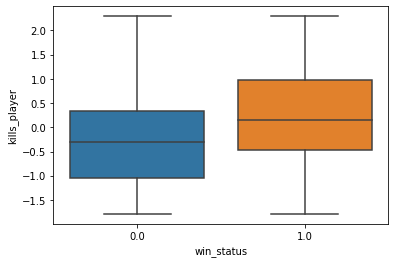

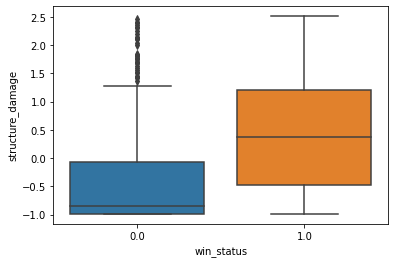

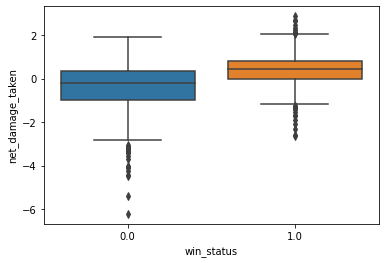

In [66]:
# First, let's plot our raw features to see any visual correlations between them and victory
for col in col_names:
    if col == 'BIAS' or col == 'win_status' or col == 'match_id':
        continue
    sbn.boxplot(data=df, x='win_status', y=col)
    plt.show()

From these plots we can clearly see that many statistics' distributions are markedly different for a win than a loss, indicating that there may be a correlation between a player's "performance data" and their chance at a victory. Let's see what all of these data points remapped into a 2-D space looks like.

In [5]:
two_d = TSNE(random_state=0, n_jobs=-1).fit_transform(df.values[:,1:-2])

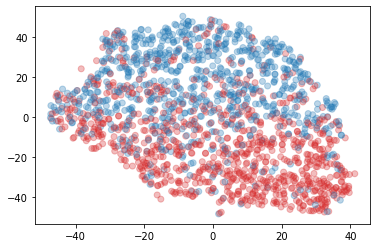

In [9]:
plt.cla()
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in df.values[:,-2]]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

Once again, the data is seperable between "unlikely to win" and "likely to win", indicating a function should fit it well. First, let's try fitting a linear function, then see how much better we can do with a nonlinear function!

In [10]:
# Obv, first step is to split into train - test
x_train, x_test, y_train, y_test = train_test_split(df.values[:,:-2], df.values[:,-2], test_size=0.33, random_state=0)

In [12]:
parameters_lrc = {
    'C': [10 ** x for x in range(-5,0)]
}
# NOTE: LOOK INTO LR_CV (the cross validated version of this, check diff params)
lrc = LogisticRegression(random_state=0)
clf_lrc = GridSearchCV(lrc, parameters_lrc, n_jobs=-1)
clf_lrc.fit(x_train, y_train.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [13]:
cl_df = pd.DataFrame(clf_lrc.cv_results_)
cl_df.loc[cl_df['rank_test_score'] == 1]
# NOTE: best params are C=0.1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.012026,0.001526,0.000577,0.000112,0.1,{'C': 0.1},0.76824,0.772532,0.806867,0.776824,0.819742,0.788841,0.020565,1


In [14]:
new_l = clf_lrc.predict(df.values[:,:-1])
clf_lrc.score(x_test,y_test)

0.7965217391304348

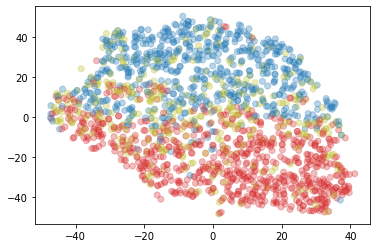

In [16]:
plt.cla()
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in new_l]
c = [e if df.values[:,-2][idx] == new_l[idx] else 'tab:olive' for idx,e in enumerate(c)]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

In [17]:
parameters_rbf = {
    'kernel': ['rbf'],
    'C': [10 ** x for x in range(-3, 3)],
    'gamma': [10 ** x for x in range(-3, 3)],
}
svm = SVC(random_state=0)

In [18]:
clf_rbf = GridSearchCV(svm, parameters_rbf, n_jobs=-1)
clf_rbf.fit(x_train, y_train.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
cr_df = pd.DataFrame(clf_rbf.cv_results_)
cr_df.loc[cr_df['rank_test_score'] == 1]
# NOTE: best params are C=100, gamma=0.001, kernel=rbf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,0.052531,0.007002,0.007849,0.000486,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.785408,0.7897,0.7897,0.781116,0.824034,0.793991,0.015355,1


In [20]:
new_l = clf_rbf.predict(df.values[:,:-1])
clf_rbf.score(x_test, y_test)

0.7965217391304348

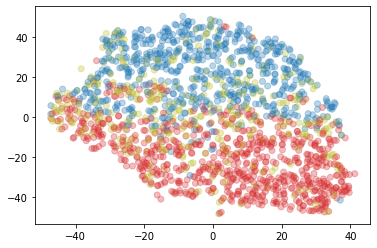

In [21]:
plt.cla()
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in new_l]
c = [e if df.values[:,-2][idx] == new_l[idx] else 'tab:olive' for idx,e in enumerate(c)]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

First, I will do some visual exploration of the data, examining the characteristics of each statistic and how it correlates to victory for a particular diety. Once the structure is complete, I intend to check it out with one diety of each class.

Next, I'd like to determine whether a linear fitter will work for the data or if a non-linear model is required. SGDC for linear, SVMC for non-linear.

After that, I need to determine if / how any data adjustment / de-fuzzing affects the final item classification accuracy. (essentially, does "correcting" the performance data labelling favorably impact the item classification accuracy?)

After that, maybe explore different classifiers for items and performance, see if you can accurately determine the performance statistics based upon the items (this would prove the performance / item correlation)

Now, I want to see if I can get even better prediction by seeing all the statistics of all the players on a team.

**Determine the noise caused by teammates and if that noise can be meaningfully reduced by taking the prediction of the linear model rather than the actual win label**

Steps:
* Load all gods, make predictions for every entry.
* Assemble all 5-man teams
* train a classifier to predict team victory based on probability of individual player victory
* See if we can do some mix-and-match, substituting ".5" percent victory predictions for teammates and seeing what the output is.
* Determine if the output of the linear classifier matches the victory predictions for teammates with a range of probabilities, from 0.25 to 0.75.

Current Idea: First, predict every individual player's likelihood of victory. Next, get the percentiles of all the probabilities (lets say by 10). Finally, count the number of players on each team who are in each percentile and then put that into a regression classifier targeting the victory label. Hopefully, this will give me a 95% plus accuracy, I'd love 99% to 100%.

In [74]:
predict_col_names = (
    'match_id',
    'prediction',
    'win_status',
)

predictions_dfs = []
for df in tqdm(all_dfs):
    lr = LogisticRegression(random_state=0, C=0.1, n_jobs=-1)
    lr.fit(df.values[:,:-2], df.values[:,-2].ravel())
    predictions_dfs.append(
        pd.DataFrame(
            np.hstack((
                df.values[:,-1].reshape((df.values.shape[0], 1)),
                np.array([
                    x[1]
                    for x in lr.predict_proba(df.values[:,:-2])
                ]).reshape(df.values.shape[0], 1),
                df.values[:,-2].reshape((df.values.shape[0], 1)),
            )),
            columns=predict_col_names,
        )
    )

100%|██████████| 111/111 [00:05<00:00, 21.58it/s]


In [75]:
predictions = pd.concat(predictions_dfs)
predictions.sort_values('match_id')
percentiles = np.percentile(predictions.values[:, 1], list(range(0,101,10)))

In [93]:
team_noise = {}
current_game = []
match_id = predictions.iloc[0]['match_id']
for i in tqdm(range(predictions.values.shape[0])):
    row = predictions.iloc[i]
    if row['match_id'] == match_id:
        current_game.append(row[['prediction', 'win_status']])
    else:
        team_noise[match_id] = deepcopy(current_game)
        current_game = []

100%|██████████| 157574/157574 [00:17<00:00, 9026.44it/s]


In [96]:
predictions.iloc[0][['prediction', 'win_status']]

prediction    0.691554
win_status    1.000000
Name: 0, dtype: float64

In [95]:
team_noise[1084688996.0]

[]